## Descargar datos
https://www.kaggle.com/mchirico/philadelphiacrimedata

In [4]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('crime.csv')

In [3]:
data.head()

,Dc_Dist,Psa,Dispatch_Date_Time,Dispatch_Date,Dispatch_Time,Hour,Dc_Key,Location_Block,UCR_General,Text_General_Code,Police_Districts,Month,Lon,Lat
0,18,3,2009-10-02 14:24:00,2009-10-02,14:24:00,14,200918067518,S 38TH ST / MARKETUT ST,800.0,Other Assaults,NaN,2009-10,NaN,NaN
1,14,1,2009-05-10 00:55:00,2009-05-10,00:55:00,0,200914033994,8500 BLOCK MITCH,2600.0,All Other Offenses,NaN,2009-05,NaN,NaN
2,25,J,2009-08-07 15:40:00,2009-08-07,15:40:00,15,200925083199,6TH CAMBRIA,800.0,Other Assaults,NaN,2009-08,NaN,NaN
3,35,D,2009-07-19 01:09:00,2009-07-19,01:09:00,1,200935061008,5500 BLOCK N 5TH ST,1500.0,Weapon Violations,20.0,2009-07,-75.130477,40.036389
4,9,R,2009-06-25 00:14:00,2009-06-25,00:14:00,0,200909030511,1800 BLOCK WYLIE ST,2600.0,All Other Offenses,8.0,2009-06,-75.166350,39.969532


## ¿Cuáles crimenes se cometieron?

In [4]:
crimes = data['Text_General_Code'].value_counts()
crimes

All Other Offenses                         437581
Other Assaults                             277332
Thefts                                     257923
Vandalism/Criminal Mischief                200345
Theft from Vehicle                         171135
Narcotic / Drug Law Violations             137448
Fraud                                      114416
Recovered Stolen Motor Vehicle              95282
Burglary Residential                        94143
Aggravated Assault No Firearm               68989
DRIVING UNDER THE INFLUENCE                 53721
Robbery No Firearm                          51919
Motor Vehicle Theft                         46517
Robbery Firearm                             40577
Disorderly Conduct                          40137
Aggravated Assault Firearm                  27934
Burglary Non-Residential                    23276
Weapon Violations                           19092
Other Sex Offenses (Not Commercialized)     15304
Prostitution and Commercialized Vice        12854


## ¿Cuál fue el crimen más y menos cometido?

In [5]:
max_crime = crimes.index[0]
min_crime = crimes.index[len(crimes)-1]
print('Más: ', max_crime)
print('Menos: ', min_crime)

Más:  All Other Offenses
Menos:  Homicide - Gross Negligence


## ¿En qué lugares ocurrió el crimen menos cometido? 

In [6]:
min_crime_locations = data[data['Text_General_Code'] == min_crime]['Location_Block'].unique()
list(min_crime_locations)

['2200 BLOCK RHAWN ST',
 '6600 BLOCK N 8TH ST',
 '2100 BLOCK MARKET ST',
 'N BROAD ST  / W GLENWOOD AV',
 '500 BLOCK SENTNER ST',
 '2700 BLOCK RHAWN ST',
 '0 BLOCK E WALNUT LN']

## ¿A qué horas ocurrieron los crimenes?

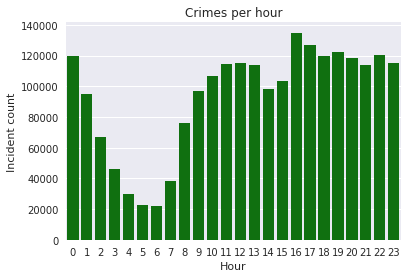

In [7]:
sns.set()
sns.countplot(data['Hour'], color='green')
plt.title("Crimes per hour")
plt.xlabel("Hour")
plt.ylabel("Incident count")
plt.show()

## ¿Cuáles son las horas y distritos con más crimenes?

### Eliminar las columnas innecesarias

In [6]:
columns = set(data)
columns = columns - set(['Hour', 'Dc_Dist'])

hour_district = data.drop(columns, axis=1)

### Contar los crimenes por hora y distrito

In [9]:
hour_district['Occurrences'] = 1
hour_district = hour_district.groupby(["Dc_Dist", "Hour"]).size().reset_index(name="Occurrences")
hour_district.head()

,Dc_Dist,Hour,Occurrences
0,1,0,3060
1,1,1,2186
2,1,2,1539
3,1,3,1176
4,1,4,795


### Graficar

In [10]:
hour_district = hour_district.pivot("Dc_Dist", "Hour", "Occurrences")
hour_district.fillna(0, inplace=True)

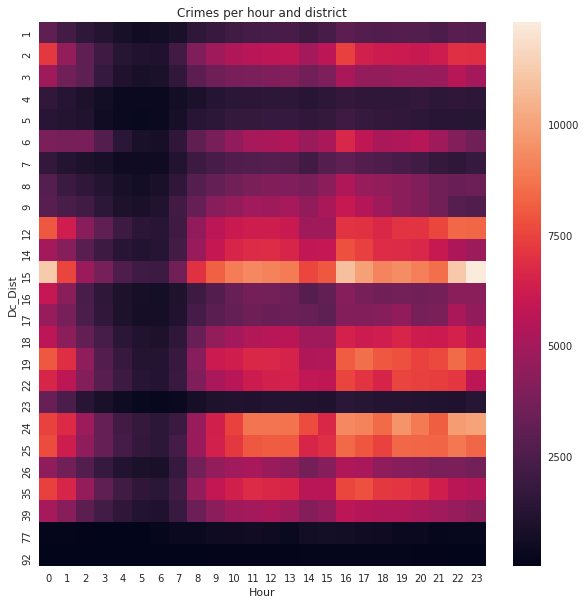

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.title("Crimes per hour and district")
ax = sns.heatmap(hour_district)
plt.show()

## ¿Cuándo y dónde ocurrió un crimen específico?

In [26]:
crime = input("Crimen: ")

Crimen: Rape


In [27]:
columns = set(data)
columns = columns - set(['Hour', 'Dc_Dist'])

hour_district = data[data['Text_General_Code'] == crime]
hour_district = hour_district.drop(columns, axis=1)

In [28]:
hour_district['Occurrences'] = 1
hour_district = hour_district.groupby(["Dc_Dist", "Hour"]).size().reset_index(name="Occurrences")
hour_district.head()

,Dc_Dist,Hour,Occurrences
0,1,0,4
1,1,1,4
2,1,2,4
3,1,3,6
4,1,4,7


In [29]:
hour_district = hour_district.pivot("Dc_Dist", "Hour", "Occurrences")
hour_district.fillna(0, inplace=True)

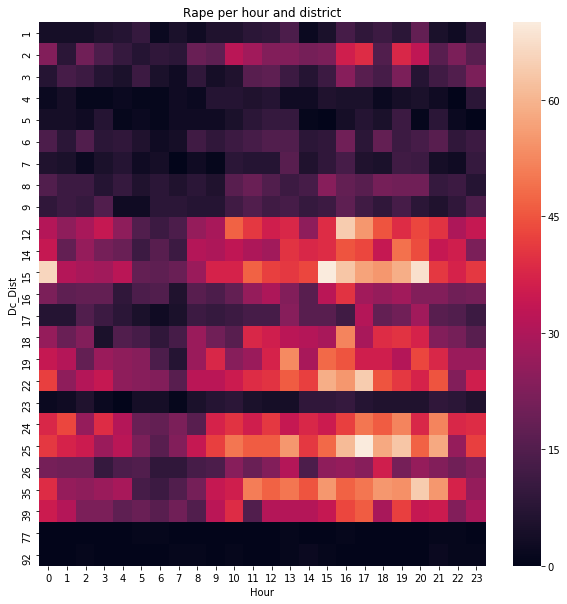

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.title("{} per hour and district".format(crime))
ax = sns.heatmap(hour_district)
plt.show()

## ¿Cuál es la probabilidad de que un crimen ocurrido en cualquier lugar sea un homicidio?

### Transformar los crimenes de homicidio en un solo tipo

In [12]:
homicide_types = ['Homicide - Criminal', 'Homicide - Justifiable', 'Homicide - Gross Negligence']
data.loc[data['Text_General_Code'].isin(homicide_types), 'Text_General_Code'] = 'Homicide'

In [13]:
import numpy as np
from scipy.stats import beta as beta_distribution

### Hallar probabilidades 

In [14]:
num_crimes = data.shape[0]
num_crime_occurrences = data['Text_General_Code'].value_counts()['Homicide']

alpha = 1 + num_crime_occurrences
beta = 1 + (num_crimes - num_crime_occurrences)

x_values = np.linspace(0, 1, 1002)[1:-1]
pdf_y_values = beta_distribution(alpha, beta).pdf(x_values)
cdf_y_values = np.cumsum(pdf_y_values) / np.sum(pdf_y_values)

### Graficar probabilidades 

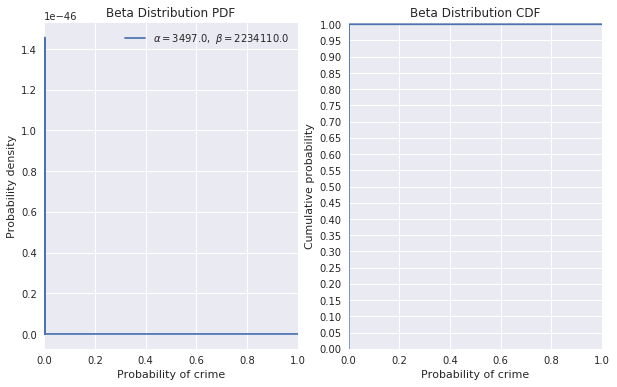

In [15]:
plt.figure(figsize=(10, 6))

# PDF
plt.subplot(121)

plt.plot(x_values, pdf_y_values, label=(r'$\alpha=%.1f,\ \beta=%.1f$' % (alpha, beta)))

plt.xlim(0, 1)
plt.xlabel('Probability of crime')
plt.ylabel('Probability density')
plt.title('Beta Distribution PDF')
plt.legend(loc=1)

# CDF
plt.subplot(122)

plt.plot(x_values, cdf_y_values)

plt.xlim(0, 1)
plt.ylim(0, 1.005)
plt.yticks(np.linspace(0, 1, 21))
plt.xlabel('Probability of crime')
plt.ylabel('Cumulative probability')
plt.title('Beta Distribution CDF')

plt.show()

### Calcular la verdadera probabilidad 

In [16]:
percentile = max(
    [x_value for x_value, y_value in zip(x_values, cdf_y_values) if y_value <= .99]
)

print('La verdadera probabilidad es: {}'.format(round(percentile, 4)))

La verdadera probabilidad es: 0.001


## ¿Cuáles crimenes son similares a homicidio con respecto a los lugares donde ocurren?

In [17]:
similarities_data = data
similarities_data.head()

,Dc_Dist,Psa,Dispatch_Date_Time,Dispatch_Date,Dispatch_Time,Hour,Dc_Key,Location_Block,UCR_General,Text_General_Code,Police_Districts,Month,Lon,Lat
0,18,3,2009-10-02 14:24:00,2009-10-02,14:24:00,14,200918067518,S 38TH ST / MARKETUT ST,800.0,Other Assaults,NaN,2009-10,NaN,NaN
1,14,1,2009-05-10 00:55:00,2009-05-10,00:55:00,0,200914033994,8500 BLOCK MITCH,2600.0,All Other Offenses,NaN,2009-05,NaN,NaN
2,25,J,2009-08-07 15:40:00,2009-08-07,15:40:00,15,200925083199,6TH CAMBRIA,800.0,Other Assaults,NaN,2009-08,NaN,NaN
3,35,D,2009-07-19 01:09:00,2009-07-19,01:09:00,1,200935061008,5500 BLOCK N 5TH ST,1500.0,Weapon Violations,20.0,2009-07,-75.130477,40.036389
4,9,R,2009-06-25 00:14:00,2009-06-25,00:14:00,0,200909030511,1800 BLOCK WYLIE ST,2600.0,All Other Offenses,8.0,2009-06,-75.166350,39.969532


### Eliminar las columnas innecesarias 

In [18]:
columns = set(similarities_data)
columns = columns - set(['Text_General_Code', 'Location_Block'])
list(columns)

['Lat',
 'Lon',
 'Dispatch_Date_Time',
 'Dispatch_Date',
 'Hour',
 'Dc_Dist',
 'Dispatch_Time',
 'Dc_Key',
 'Month',
 'UCR_General',
 'Police_Districts',
 'Psa']

In [19]:
similarities_data = similarities_data.drop(columns, axis=1)
similarities_data.head()

,Location_Block,Text_General_Code
0,S 38TH ST / MARKETUT ST,Other Assaults
1,8500 BLOCK MITCH,All Other Offenses
2,6TH CAMBRIA,Other Assaults
3,5500 BLOCK N 5TH ST,Weapon Violations
4,1800 BLOCK WYLIE ST,All Other Offenses


### Contar los crimenes por localización

In [20]:
similarities_data['Occurrence'] = 1
similarities_data.groupby(['Text_General_Code', 'Location_Block']).count().sort_values('Occurrence', ascending=False)
similarities_data.fillna(0, inplace=True)

In [21]:
similarities_data = similarities_data.drop_duplicates()
similarities_data.shape

(484894, 3)

In [22]:
similarities_data.head()

,Location_Block,Text_General_Code,Occurrence
0,S 38TH ST / MARKETUT ST,Other Assaults,1
1,8500 BLOCK MITCH,All Other Offenses,1
2,6TH CAMBRIA,Other Assaults,1
3,5500 BLOCK N 5TH ST,Weapon Violations,1
4,1800 BLOCK WYLIE ST,All Other Offenses,1


### Crear matriz que se utiliza en las funciones de similaridad

In [23]:
crimes_matrix = similarities_data.reset_index() \
    .pivot(index='Text_General_Code', columns='Location_Block', values='Occurrence') \
    .fillna(0) \
    .astype(int)

In [24]:
crimes_matrix.head()

Location_Block,"""A"" ST & WESTMORELAND ST","""A"" ST. & WESTMORELAND ST","""F"" CHECKPOINT","""F"" TERMINAL @ 98 PIA WAY",(5700) GERMANTOWN AND CHELTEN AVENUES,-2 CARGO CITY,-300 BUSTI PLACE - APT. 704,-WEST GATE 22,.5100 OGDEN ST,/C BAGGAGE,...,`42 S 8TH ST,`500 MARKET ST,`51 E GORGAS LN,`523 LIMEKILN PIKE,`531 N GRATZ ST,`603 N 6TH ST,`653 S 2ND ST,`700 FRONTENAC ST,`700 SPRUCE ST,`732 SIGEL ST
Text_General_Code,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aggravated Assault Firearm,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aggravated Assault No Firearm,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
All Other Offenses,0,0,0,0,0,0,0,0,0,1,...,1,1,0,1,0,0,0,0,0,0
Arson,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Muestra en cuantos lugares ha ocurrido cada crimen
crimes_matrix.sum(axis=1)

Text_General_Code
0                                            235
Aggravated Assault Firearm                 12733
Aggravated Assault No Firearm              21926
All Other Offenses                         44272
Arson                                       4457
Burglary Non-Residential                    7452
Burglary Residential                       19580
DRIVING UNDER THE INFLUENCE                21585
Disorderly Conduct                         12039
Embezzlement                                1998
Forgery and Counterfeiting                  2996
Fraud                                      23725
Gambling Violations                          546
Homicide                                    2875
Liquor Law Violations                       1783
Motor Vehicle Theft                        21108
Narcotic / Drug Law Violations             25298
Offenses Against Family and Children        1381
Other Assaults                             41450
Other Sex Offenses (Not Commercialized)     8989
Pr

### Funciones para hallar la similaridad 

In [26]:
# Similaridad entre dos crimenes
def jaccard_similarity(crime_1, crime_2):
    crime_1_locations = set( crime_1[crime_1 > 0].index )
    crime_2_locations = set( crime_2[crime_2 > 0].index )
    intersection_length = len(crime_1_locations.intersection(crime_2_locations))
    union_length = len(crime_1_locations.union(crime_2_locations))
    
    return intersection_length / union_length

In [27]:
# Similaridad entre un crimen y todos los demás
def compute_pairwise_jaccard_similarities(query_crime_index):
    query_crime = crimes_matrix.loc[query_crime_index]
    candidate_crimes = crimes_matrix.drop(query_crime_index, axis=0)
    similarities = {}
    
    for candidate_crime_id, candidate_crime in candidate_crimes.iterrows():
        similarity = jaccard_similarity(query_crime, candidate_crime)
        similarities[candidate_crime_id] = similarity
    
    return pd.Series(similarities)

In [28]:
crimes_matrix.head()

Location_Block,"""A"" ST & WESTMORELAND ST","""A"" ST. & WESTMORELAND ST","""F"" CHECKPOINT","""F"" TERMINAL @ 98 PIA WAY",(5700) GERMANTOWN AND CHELTEN AVENUES,-2 CARGO CITY,-300 BUSTI PLACE - APT. 704,-WEST GATE 22,.5100 OGDEN ST,/C BAGGAGE,...,`42 S 8TH ST,`500 MARKET ST,`51 E GORGAS LN,`523 LIMEKILN PIKE,`531 N GRATZ ST,`603 N 6TH ST,`653 S 2ND ST,`700 FRONTENAC ST,`700 SPRUCE ST,`732 SIGEL ST
Text_General_Code,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aggravated Assault Firearm,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aggravated Assault No Firearm,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
All Other Offenses,0,0,0,0,0,0,0,0,0,1,...,1,1,0,1,0,0,0,0,0,0
Arson,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Hallar similaridades

In [29]:
similarities = compute_pairwise_jaccard_similarities('Homicide').sort_values(ascending=False)

### Graficar similaridades

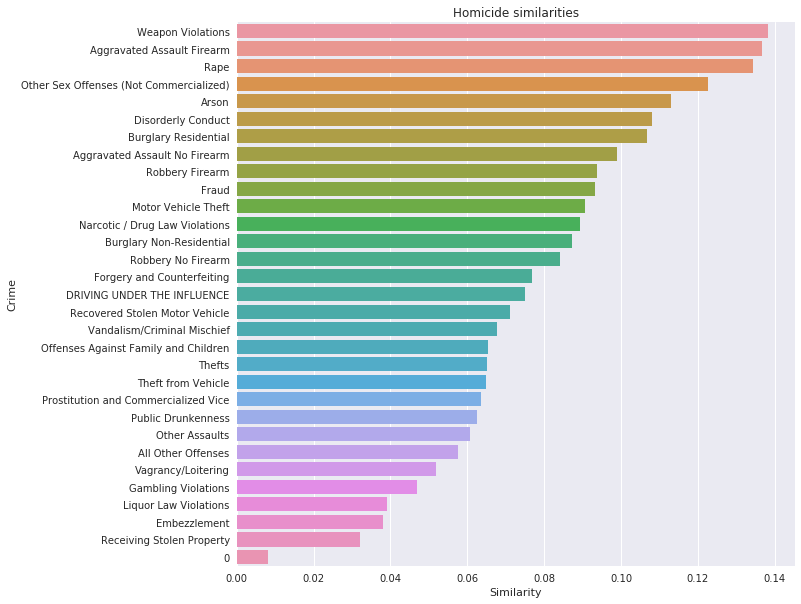

In [30]:
similarities_df = pd.DataFrame(data=similarities, columns=['Similarity'])
similarities_df.index.name = "Crime"

ax = similarities_df.plot(kind='barh', legend=False, width=.5, figsize=(10,10))
sns.barplot(x=similarities_df.Similarity, y=similarities_df.index)
plt.title("Homicide similarities")
plt.show()